# Reproducing Monodepth

Author: Xiao Bin Yu (20669364)

## Abstract

This project reproduces the Monodepth model specified here https://arxiv.org/pdf/1609.03677.pdf. The goal of reproducing the model in a Jupyter notebook is to provide a modern Tensorflow 2.x implementation of the model alongside providing comments to aid a reader of the paper in understanding the model architecture.

## Introduction

Depth estimation is an important problem in computer vision and used in many applications such as self driving cars and robotics. Depth estimation can be done in many different ways with different types of sensors such as with structured light and LIDAR. However often times we want to determine depth on images where there isn't any depth information. Also depth sensors can be restrictive in that they require space. This is why monocular depth estimation is interesting in that all we need are image.


Often stereo depth estimation is done in a supervised approach. The problem with a supervised approach is that ground truth data can often be hard to get. [Monodepth](https://arxiv.org/pdf/1609.03677.pdf) proposes training an estimation model with stereo images. The goal of Monodepth is to learn a function $f$ that can predict per pixel disparities between left and right stereo images. To learn to predict per pixel dipsarities Monodepth uses disparities to warp a left image to the right one and vice versa. Monodepth by being better at warping left-to-right and right-to-left.

In this notebook we reproduce Monodepth while annotating the steps to build the model. This notebook provides a great resource to learn the technical details of Monodepth and techniques used in unsupervised monocular depth estimation. Finally we present our reproduced results.

## Download train and test data

In [0]:
!wget -i kitti_archives_to_download.txt -P .

In [0]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_scene_flow.zip

In [0]:
%%capture
!unzip '*.zip'

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
from random import sample
from PIL import Image

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 128
BATCH_SIZE = 32
EPOCHS = 30
NUM_TRAIN_DATA = 10000
NUM_VAL_DATA = 1000
NUM_TEST_DATA = 10

## Data Loading and Augmentation

As done in the paper we:

"flip the input
images horizontally with a 50% chance"

"added color augmentations, with a
50% chance"

"by sampling from uniform distributions in
the ranges $[0.8,1.2]$ for gamma"

"$[0.5,2.0]$ for brightness"

"$[0.8,1.2]$ for each color channel separately"

In [0]:
# given file paths load images as resized float32 tensors
def read_image(l_img_path, r_img_path):
  img_l = tf.image.decode_png(tf.io.read_file(l_img_path), channels=3)
  img_r = tf.image.decode_png(tf.io.read_file(r_img_path), channels=3)
  img_l = tf.image.convert_image_dtype(img_l,  tf.float32)
  img_r = tf.image.convert_image_dtype(img_r,  tf.float32)
  # resize
  img_l = tf.image.resize(img_l, (IMG_HEIGHT, IMG_WIDTH))
  img_r = tf.image.resize(img_r, (IMG_HEIGHT, IMG_WIDTH))
  return img_l, img_r

In [0]:
def augment_image(img_l, img_r):
  # random flip
  if tf.random.uniform((), 0.0, 1.0) < 0.5:
    # need the swap images since disparity direction
    img_l, img_r = tf.image.flip_left_right(img_r), tf.image.flip_left_right(img_l)

  if tf.random.uniform((), 0.0, 1.0) < 0.5:
    # random gamma shift
    r = tf.random.uniform((), 0.8, 1.2)
    img_l **= r
    img_r **= r

    # random brighness shift
    r = tf.random.uniform((), 0.5, 2.0)
    img_l *= r
    img_r *= r

    # random colour shift
    r = tf.tile(tf.random.uniform((1, 1, 3), 0.8, 1.2), (IMG_HEIGHT, IMG_WIDTH, 1))
    img_l *= r
    img_r *= r

    img_l = tf.clip_by_value(img_l,  0, 1)
    img_r = tf.clip_by_value(img_r, 0, 1)

  return img_l, img_r

Create TF dataset and map augmentation functions

In [0]:
def get_dataset(l_fnames, r_fnames, augment=True, shuffle=True):           
  num = len(l_fnames)
  dataset = tf.data.Dataset.from_tensor_slices((l_fnames, r_fnames))
  dataset = dataset.map(read_image, num_parallel_calls=5)
  if augment:
      dataset = dataset.map(augment_image, num_parallel_calls=5)  
  dataset = dataset.map(lambda l, r: ({'img_l': l, 'img_r': r}))
  if shuffle:
      dataset = dataset.shuffle(num)
  dataset = dataset.batch(BATCH_SIZE)
  return dataset

In [0]:
l_fnames = glob.glob('./**/**/image_02/data/*.png')
r_fnames = glob.glob('./**/**/image_03/data/*.png')

train_idx = sample(range(len(l_fnames)),NUM_TRAIN_DATA)
train_l = [l_fnames[i] for i in train_idx]
train_r = [r_fnames[i] for i in train_idx]
train_dataset = get_dataset(train_l, train_r)
TRAIN_SIZE = len(train_l)
print("TRAIN SIZE ", TRAIN_SIZE)

val_idx = sample(range(len(l_fnames)),NUM_VAL_DATA)
val_l = [l_fnames[i] for i in val_idx]
val_r = [r_fnames[i] for i in val_idx]
val_dataset = get_dataset(val_l, val_r)
VAL_SIZE = len(val_l)
print("VAL SIZE ", VAL_SIZE)

test_idx = sample(range(len(l_fnames)),NUM_TEST_DATA)
test_l = [l_fnames[i] for i in test_idx]
test_r = [r_fnames[i] for i in test_idx]
test_dataset = get_dataset(test_l, test_r, augment=False)
TEST_SIZE = len(test_l)
print("TEST SIZE ", TEST_SIZE)

TRAIN SIZE  10000
VAL SIZE  1000
TEST SIZE  10


In [0]:
sample_test = next(iter(test_dataset))

Text(0.5, 1.0, 'Right stereo image')

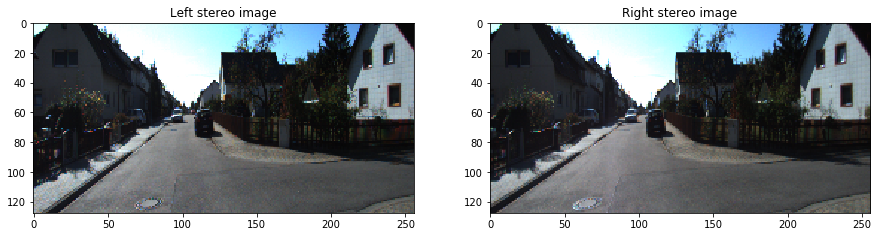

In [0]:
f, axarr = plt.subplots(1,2, figsize=(15,15))
axarr[0].imshow(sample_test['img_l'][0])
axarr[0].set_title('Left stereo image')
axarr[1].imshow(sample_test['img_r'][0])
axarr[1].set_title('Right stereo image')

## Bilinear Sampling

Bilinear sampling is a technique to warp from one image to another using the disparities. Bilinear sampling takes the float disparity values $D(x,y)$ and the original image $I(x,y)$ and computes 

$I(\alpha floor[(x,y)+wD(x,y)] + \beta ceil[(x,y)+wD(x,y)])$ 

$\alpha = 1-((x,y)+wD(x,y) - floor[(x,y)+wD(x,y)])$

$\beta = 1-(ceil[(x,y)+wD(x,y)] - (x,y)+wD(x,y))$

where $w$ is the width of the image.

0 is returned on the undefined regions. 

It is bilinear in the sense that disparity shifts can result in inbetween pixels that are bilinearly interpolated.


In [0]:
def bilinear_sample(img, disp):
    batch_size = tf.shape(img)[0]
    img_h = tf.shape(img)[1]
    img_w = tf.shape(img)[2]

    # get x indices
    img_x = tf.range(0, img_w)
    img_x = tf.reshape(img_x, (1, 1, img_w))
    img_x = tf.tile(img_x, (batch_size, img_h, 1))
    img_x = tf.cast(img_x, 'float32')

    # get x indices + disp
    img_t = img_x + disp * tf.cast(img_w, 'float32')

    # get the left and right indices
    img_t_l = tf.math.floor(img_t)
    img_t_r = img_t_l + 1

    # get the bilinear ratio
    img_diff_l = tf.expand_dims(1 - (img_t - img_t_l), axis=-1)
    img_diff_r = tf.expand_dims(1 - (img_t_r - img_t), axis=-1)

    img_t_l = tf.cast(img_t_l, 'int32')
    img_t_r = tf.cast(img_t_r, 'int32')

    # limit indices so they dont go out of bounds where edges are 0
    img_t_l = tf.clip_by_value(img_t_l, 0, img_w)
    img_t_r = tf.clip_by_value(img_t_r, 0, img_w)

    # batch indices
    img_batch = tf.range(0, batch_size)
    img_batch = tf.reshape(img_batch, (batch_size, 1, 1))
    img_batch = tf.tile(img_batch, (1, img_h, img_w))

    # y indices
    img_y = tf.range(0, img_h)
    img_y = tf.reshape(img_y, (1, img_h, 1))
    img_y = tf.tile(img_y, (batch_size, 1, img_w))

    # pad border of image with 0
    img = tf.pad(img, [[0, 0], [1, 1], [1, 1], [0, 0]])
    img_y += 1
    img_t_l += 1
    img_t_r += 1

    # get pixel value
    ind_l = tf.stack([img_batch, img_y, img_t_l], -1)
    ind_r = tf.stack([img_batch, img_y, img_t_r], -1)
    img_l = tf.gather_nd(img, ind_l)
    img_r = tf.gather_nd(img, ind_r)

    # bilinear
    return img_diff_l * img_l + img_diff_r * img_r

## Training Loss

Monodepth uses 3 loss functions.

1. Appearance matching loss to encourage generated right and left images to match the true counter parts

2. Disparity smoothness loss to ensure disparities are smooth

3. Left-Right disparity consistency loss to make sure left-view disparity map is equal to the projected right-view disparity map.

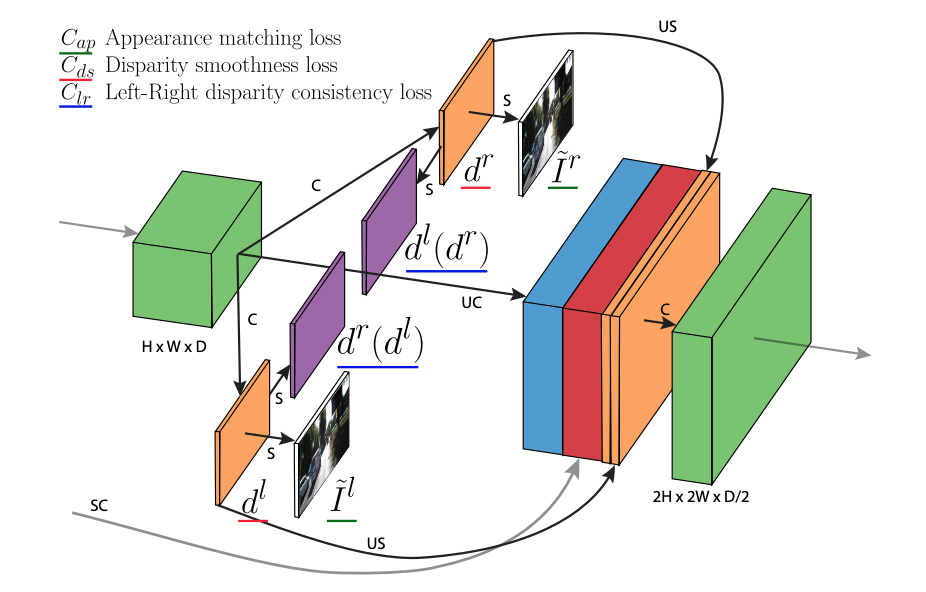

### Appearance Matching Loss

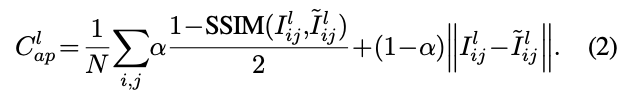

In [0]:
def am_loss(imgs, imgs_est):
    l1 = [tf.reduce_mean(tf.abs(imgs[i] - imgs_est[i])) for i in range(4)]
    dssim = [tf.reduce_mean(
          (1 - tf.image.ssim(imgs[i], imgs_est[i], max_val=1, filter_size=11)) / 2) for i in
              range(4)]
    img_loss = [ALPHA * dssim[i] + (1 - ALPHA) * l1[i] for i in range(4)]
    return tf.add_n(img_loss)

### Disparity Smoothness Loss

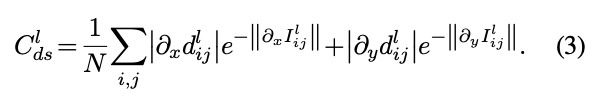

In [0]:
def g_x(img):
    return img[:,:,:-1,:] - img[:,:,1:,:]

def g_y(img):
    return img[:,:-1,:,:] - img[:,1:,:,:]

def ds_loss(imgs, disps):
    d_g_x = [tf.squeeze(g_x(tf.expand_dims(d, -1)), -1) for d in disps]
    d_g_y = [tf.squeeze(g_y(tf.expand_dims(d, -1)), -1) for d in disps]

    img_gx = [g_x(img) for img in imgs]
    img_gy = [g_y(img) for img in imgs]

    s_x = [
        tf.reduce_mean(tf.abs(
            d_g_x[i] *
            tf.math.exp(-tf.reduce_mean(tf.abs(img_gx[i]), axis=-1)))) / (2**i)
        for i in range(4)
    ]
    s_y = [
        tf.reduce_mean(tf.abs(
            d_g_y[i] *
            tf.math.exp(-tf.reduce_mean(tf.abs(img_gy[i]), axis=-1)))) / (2**i)
        for i in range(4)
    ]
    return tf.add_n(s_x + s_y)

### Left-Right Disparity Consistency Loss

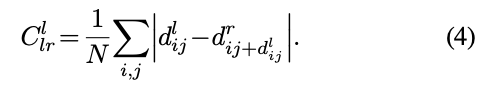

In [0]:
def lr_loss(lr_disps, disps):
    return tf.add_n([
        tf.reduce_mean(tf.abs(lr_disps[i] - disps[i])) for i in range(4)
    ])

### Combining the Losses

In here we generate the left and right projected images and compute the loss.

We use $\alpha_{ap}=1, \alpha_{ds}=0.1, \alpha_{lr}=1, \alpha=0.85$ like in the paper.

In [0]:
ALPHA = 0.85
ALPHA_AP = 1
ALPHA_LR = 1
ALPHA_DS = 0.1

def get_loss(img_l, img_r, disps_l, disps_r):
    img_h = tf.shape(img_l)[1]
    img_w = tf.shape(img_l)[2]

    imgs_l = [img_l,
              tf.image.resize(img_l, (img_h / 2, img_w / 2)),
              tf.image.resize(img_l, (img_h / 4, img_w / 4)),
              tf.image.resize(img_l, (img_h / 8, img_w / 8))]
    imgs_r = [img_r,
              tf.image.resize(img_r, (img_h / 2, img_w / 2)),
              tf.image.resize(img_r, (img_h / 4, img_w / 4)),
              tf.image.resize(img_r, (img_h / 8, img_w / 8))]

    imgs_est_l = [bilinear_sample(imgs_r[i], -disps_l[i]) for i in range(4)]
    imgs_est_r = [bilinear_sample(imgs_l[i], disps_r[i]) for i in range(4)]
    r2l_disp = [tf.squeeze(bilinear_sample(tf.expand_dims(disps_r[i], -1), -disps_l[i]), -1) for i in range(4)]
    l2r_disp = [tf.squeeze(bilinear_sample(tf.expand_dims(disps_l[i], -1), disps_r[i]), -1) for i in range(4)]

    # appearance matching loss
    img_l_loss = am_loss(imgs_l, imgs_est_l)
    img_r_loss = am_loss(imgs_r, imgs_est_r)
    img_loss = img_l_loss + img_r_loss

    # disparity smoothness loss
    ds_l_loss = ds_loss(imgs_l, disps_l)
    ds_r_loss = ds_loss(imgs_r, disps_r)
    ds_im_loss = ds_l_loss + ds_r_loss

    # left-right disparity consistency loss
    lr_l_loss = lr_loss(r2l_disp, disps_l)
    lr_r_loss = lr_loss(l2r_disp, disps_r)
    lr_im_loss = lr_l_loss + lr_r_loss

    return ALPHA_AP * img_loss + ALPHA_DS * ds_im_loss + ALPHA_LR * lr_im_loss

## Model

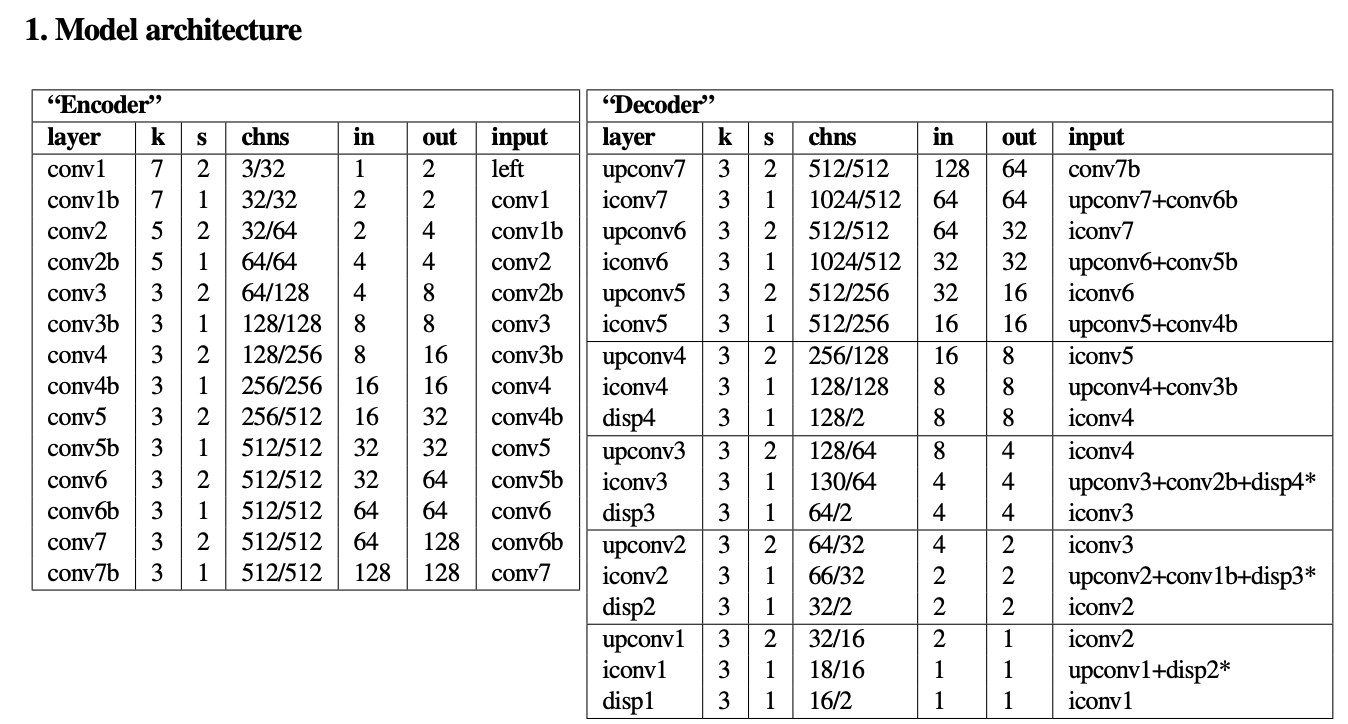

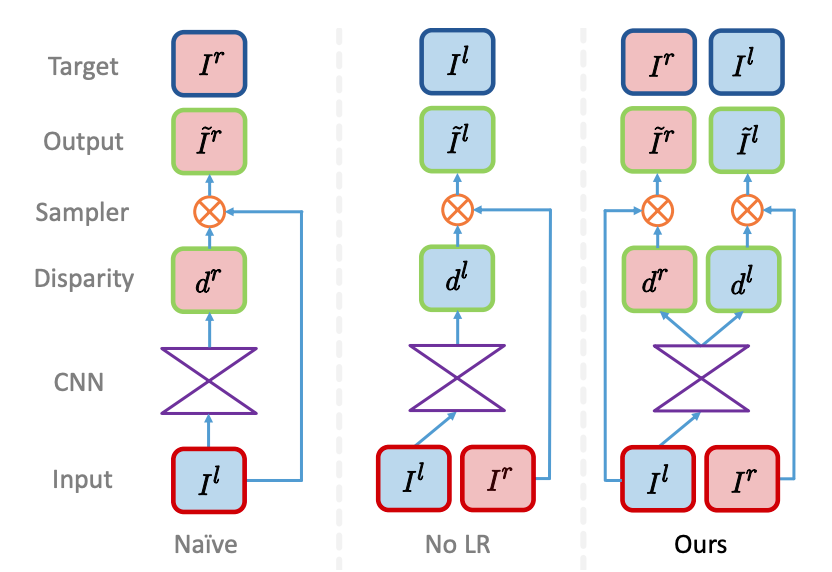

**Notes about the architecture:**

*   Deconvolutions are replaced with nearest neighbour upsampling + convolution
*   Disparities are constrained to be between $0$ and $Dmax=0.3$ using a
scaled sigmoid
*   elu is used as the activation function
*   4 Disparties are generated for left and right images corresponding to image width and height divided by $1, 2, 4, 8$. The loss is also calculated for all 8 disparities and averaged.
*   We use a gaussian 11x11 gaussian filter for SSIM rather than the 3x3 block filter specified in the paper.


In [0]:
activ = 'elu'

def get_conv_block(inp, k, chns, name):
    conv = keras.layers.Conv2D(chns, k, strides=1, padding='same',
                               activation=activ, name=name)(inp)
    convb = keras.layers.Conv2D(chns, k, strides=2, padding='same',
                                activation=activ, name=name+'b')(conv)
    return convb


# bilinear sample
def get_upconv_block(inp, k, chns, name):
    up = keras.layers.UpSampling2D(2, interpolation='nearest', name='up'+name)(inp)
    conv = keras.layers.Conv2D(chns, k, strides=1, padding='same',
                               activation=activ, name='upconv'+name)(up)
    return conv


def get_model(img_h, img_w):
    img_l = keras.layers.Input(shape=(img_h, img_w, 3), name='img_l')
    img_r = keras.layers.Input(shape=(img_h, img_w, 3), name='img_r')

    inp = keras.layers.Concatenate()([img_l, img_r])

    # encoder
    conv1 = get_conv_block(inp, 7, 32, 'conv1')
    conv2 = get_conv_block(conv1, 5, 64, 'conv2')
    conv3 = get_conv_block(conv2, 3, 128, 'conv3')
    conv4 = get_conv_block(conv3, 3, 256, 'conv4')
    conv5 = get_conv_block(conv4, 3, 512, 'conv5')
    conv6 = get_conv_block(conv5, 3, 512, 'conv6')
    conv7 = get_conv_block(conv6, 3, 512, 'conv7')

    # decoder
    upconv7 = get_upconv_block(conv7, 3, 512, '7')
    concat7 = keras.layers.Concatenate()([upconv7, conv6])
    iconv7 = keras.layers.Conv2D(512, 3, strides=1, padding='same',
                                 activation=activ, name='iconv7')(concat7)

    upconv6 = get_upconv_block(iconv7, 3, 512, '6')
    concat6 = keras.layers.Concatenate()([upconv6, conv5])
    iconv6 = keras.layers.Conv2D(512, 3, strides=1, padding='same',
                                 activation=activ, name='iconv6')(concat6)

    upconv5 = get_upconv_block(iconv6, 3, 256, '5')
    concat5 = keras.layers.Concatenate()([upconv5, conv4])
    iconv5 = keras.layers.Conv2D(256, 3, strides=1, padding='same',
                                 activation=activ, name='iconv5')(concat5)

    upconv4 = get_upconv_block(iconv5, 3, 128, '4')
    concat4 = keras.layers.Concatenate()([upconv4, conv3])
    iconv4 = keras.layers.Conv2D(128, 3, strides=1, padding='same',
                                 activation=activ, name='iconv4')(concat4)
    disp4 = 0.3 * keras.layers.Conv2D(2, 3, strides=1, padding='same',
                                      activation='sigmoid', name='disp4')(iconv4)
    up_disp4 = keras.layers.UpSampling2D(2, interpolation='nearest')(disp4)

    upconv3 = get_upconv_block(iconv4, 3, 64, '3')
    concat3 = keras.layers.Concatenate()([upconv3, conv2, up_disp4])
    iconv3 = keras.layers.Conv2D(64, 3, strides=1, padding='same',
                                 activation=activ, name='iconv3')(concat3)
    disp3 = 0.3 * keras.layers.Conv2D(2, 3, strides=1, padding='same',
                                      activation='sigmoid', name='disp3')(iconv3)
    up_disp3 = keras.layers.UpSampling2D(2, interpolation='nearest')(disp3)

    upconv2 = get_upconv_block(iconv3, 3, 32, '2')
    concat2 = keras.layers.Concatenate()([upconv2, conv1, up_disp3])
    iconv2 = keras.layers.Conv2D(32, 3, strides=1, padding='same',
                                 activation=activ, name='iconv2')(concat2)
    disp2 = 0.3 * keras.layers.Conv2D(2, 3, strides=1, padding='same',
                                      activation='sigmoid', name='disp2')(iconv2)
    up_disp2 = keras.layers.UpSampling2D(2, interpolation='nearest')(disp2)

    upconv1 = get_upconv_block(iconv2, 3, 16, '1')
    concat1 = keras.layers.Concatenate()([upconv1, up_disp2])
    iconv1 = keras.layers.Conv2D(16, 3, strides=1, padding='same',
                                 activation=activ, name='iconv1')(concat1)
    disp1 = 0.3 * keras.layers.Conv2D(2, 3, strides=1, padding='same',
                                      activation='sigmoid', name='disp1')(iconv1)

    disps_l = [disp1[:,:,:,0], disp2[:,:,:,0], disp3[:,:,:,0], disp4[:,:,:,0]]
    disps_r = [disp1[:,:,:,1], disp2[:,:,:,1], disp3[:,:,:,1], disp4[:,:,:,1]]

    model = keras.Model(inputs=[img_l, img_r], outputs=[img_l, img_r, disps_l, disps_r])

    return model

## Training

In [0]:
model = get_model(IMG_HEIGHT, IMG_WIDTH)

Train for 30 epochs

In [0]:
train_loss_results = []
val_loss_results = []

lr = 1e-4
  
def get_lr():
  global lr
  return lr

optimizer = tf.keras.optimizers.Adam(get_lr)

def grad(model, inputs):
  with tf.GradientTape() as tape:
    img_l, img_r, disps_l, disps_r = model(inputs)
    loss_value = get_loss(img_l, img_r, disps_l, disps_r)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

def train(epochs):
    for epoch in range(epochs):
      epoch_loss_avg = tf.keras.metrics.Mean()
      epoch_loss_val_avg = tf.keras.metrics.Mean()
      bar = tf.keras.utils.Progbar(target=TRAIN_SIZE)

      for inp in train_dataset:
        loss_value, grads = grad(model, inp)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        epoch_loss_avg(loss_value)
        bar.add(inp['img_l'].shape[0])

      if epoch >= 20 and epoch % 3 == 0:
        lr /= 2

      for inp in val_dataset:
        img_l, img_r, disps_l, disps_r = model(inp)
        loss_value = get_loss(img_l, img_r, disps_l, disps_r)
        epoch_loss_val_avg(loss_value)

      train_loss_results.append(epoch_loss_avg.result())
      val_loss_results.append(epoch_loss_val_avg.result())

      model.save('model{}.h5'.format(epoch))

      print("Epoch {:02d}: Loss: {:.3f}  Val Loss: {:.3f}".format(
          epoch, epoch_loss_avg.result(), epoch_loss_val_avg.result()))
        
train(EPOCHS)

10000/10000 [==============================] - 501s 50ms/step
Epoch 00: Loss: 1.228  Val Loss: 1.059
10000/10000 [==============================] - 466s 47ms/step
Epoch 01: Loss: 0.957  Val Loss: 0.870
10000/10000 [==============================] - 466s 47ms/step
Epoch 02: Loss: 0.801  Val Loss: 0.756
10000/10000 [==============================] - 466s 47ms/step
Epoch 03: Loss: 0.739  Val Loss: 0.718
10000/10000 [==============================] - 466s 47ms/step
Epoch 04: Loss: 0.708  Val Loss: 0.695
10000/10000 [==============================] - 466s 47ms/step
Epoch 05: Loss: 0.688  Val Loss: 0.683
10000/10000 [==============================] - 465s 46ms/step
Epoch 06: Loss: 0.672  Val Loss: 0.660
10000/10000 [==============================] - 464s 46ms/step
Epoch 07: Loss: 0.659  Val Loss: 0.650
10000/10000 [==============================] - 464s 46ms/step
Epoch 08: Loss: 0.645  Val Loss: 0.644
10000/10000 [==============================] - 463s 46ms/step
Epoch 09: Loss: 0.636  Val Lo

Train for 20 more epochs since it has not converged fully yet

In [0]:
train(20)

10000/10000 [==============================] - 464s 46ms/step
Epoch 00: Loss: 0.529  Val Loss: 0.540
10000/10000 [==============================] - 465s 47ms/step
Epoch 01: Loss: 0.527  Val Loss: 0.541
10000/10000 [==============================] - 464s 46ms/step
Epoch 02: Loss: 0.526  Val Loss: 0.541
10000/10000 [==============================] - 463s 46ms/step
Epoch 03: Loss: 0.525  Val Loss: 0.540
10000/10000 [==============================] - 463s 46ms/step
Epoch 04: Loss: 0.524  Val Loss: 0.535
10000/10000 [==============================] - 464s 46ms/step
Epoch 05: Loss: 0.524  Val Loss: 0.535
10000/10000 [==============================] - 463s 46ms/step
Epoch 06: Loss: 0.523  Val Loss: 0.537
10000/10000 [==============================] - 465s 47ms/step
Epoch 07: Loss: 0.521  Val Loss: 0.536
10000/10000 [==============================] - 463s 46ms/step
Epoch 08: Loss: 0.520  Val Loss: 0.538
10000/10000 [==============================] - 464s 46ms/step
Epoch 09: Loss: 0.520  Val Lo

It looks like we can still improve the validation loss if we train more but we will stop here for now.

In [0]:
model.save('model_final.h5')

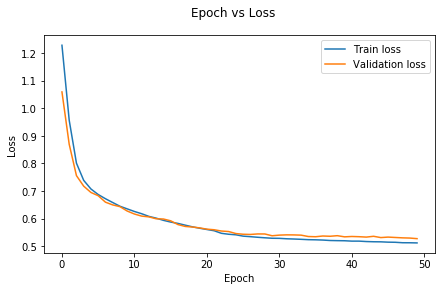

In [0]:
plt.figure(figsize=(7,4))
plt.plot(train_loss_results, label='Train loss')
plt.plot(val_loss_results, label="Validation loss")
plt.suptitle('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation on Test Images

In [0]:
def run_on_test(sample_test, start, num_to_show=5, gt=None):
    img_l, img_r, disps_l, disps_r = model(sample_test)
    
    f, axarr = plt.subplots(num_to_show,4, figsize=(30,20), gridspec_kw = {'wspace': 0, 'hspace':0.1})
    [axi.set_axis_off() for axi in axarr.ravel()]
    
    reconstruct = bilinear_sample(img_r, -disps_l[0])
    
    for i in range(num_to_show):
        axarr[i,0].imshow(sample_test['img_l'][start+i])
        axarr[i,0].set_title('Left stereo image')
        axarr[i,1].imshow(reconstruct[start+i])
        axarr[i,1].set_title('Constructed left image using disparities')
        if not gt:
            axarr[i,2].imshow(sample_test['img_r'][start+i])
            axarr[i,2].set_title('Right stereo image')
            axarr[i,3].imshow(disps_l[0][start+i], cmap='plasma')
            axarr[i,3].set_title('Predicted disparity map')
        else:
            axarr[i,2].imshow(disps_l[0][start+i], cmap='plasma')
            axarr[i,2].set_title('Predicted disparity map')
            im = Image.open(gt[i]).resize((IMG_WIDTH, IMG_HEIGHT), Image.BILINEAR)
            axarr[i,3].imshow(np.array(im), cmap='plasma')
            axarr[i,3].set_title('Ground truth')

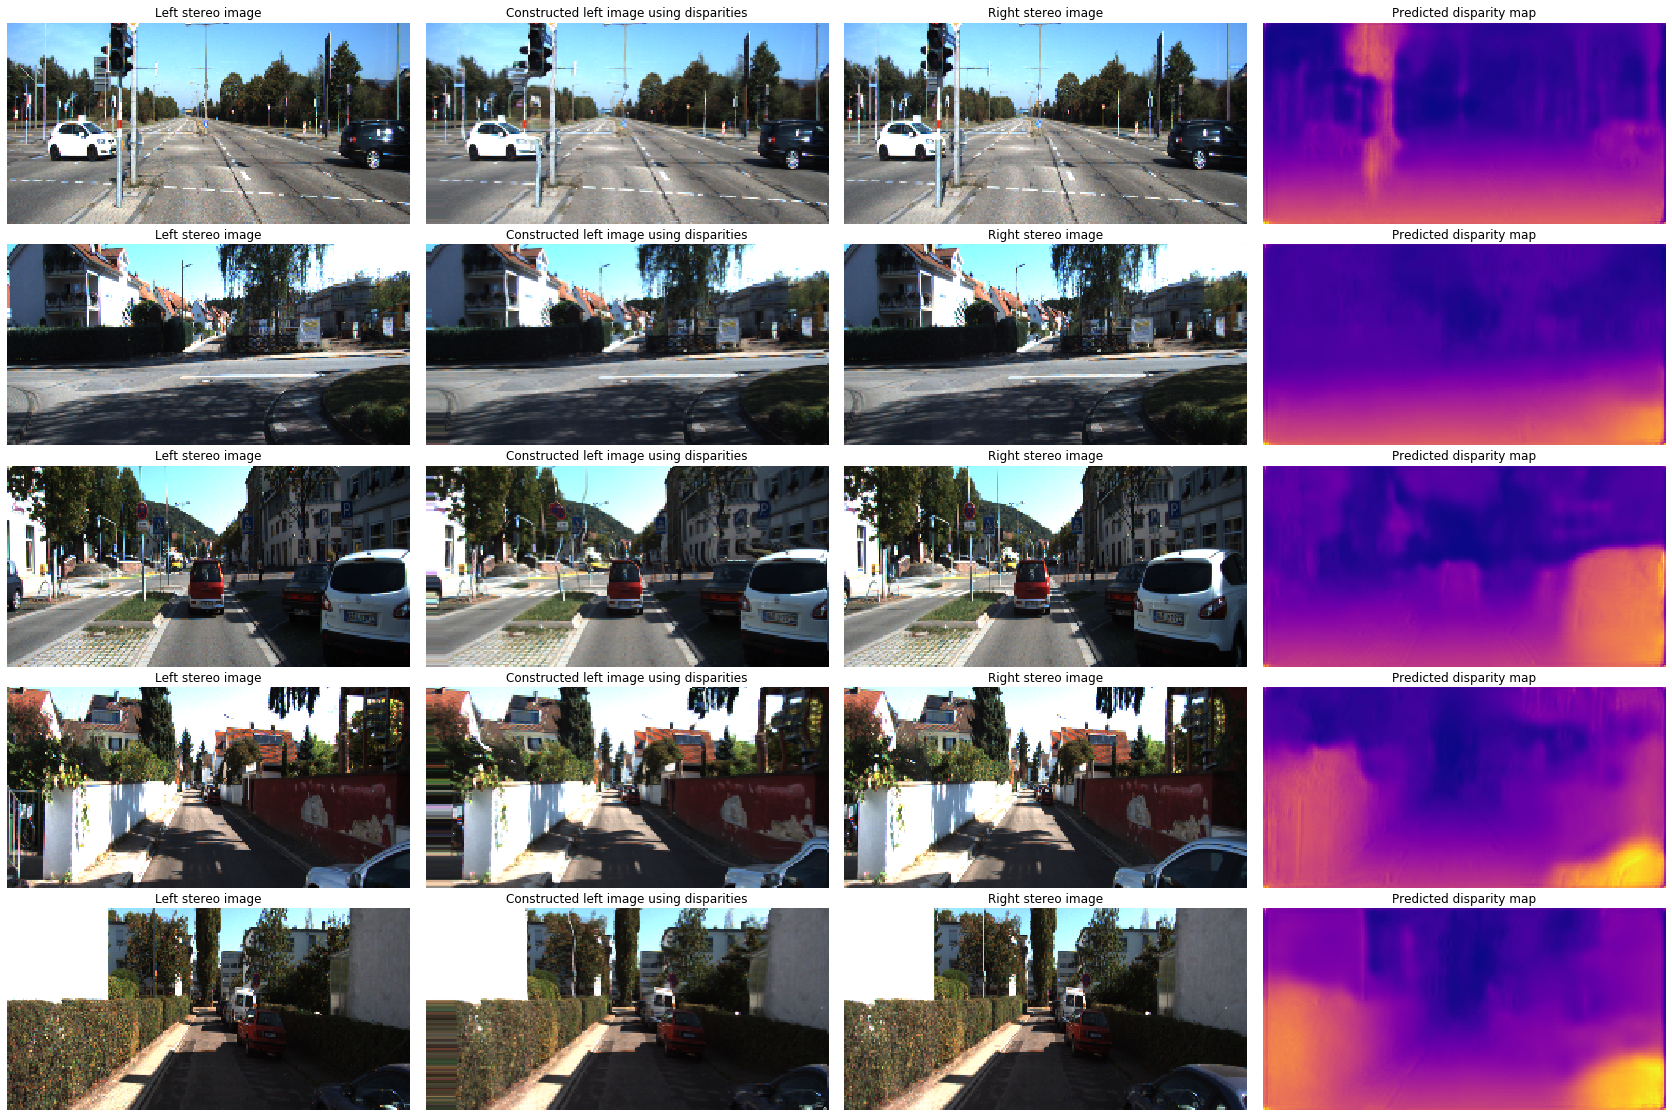

In [0]:
run_on_test(sample_test, 5, 5)

## Evaluation with GT

In [0]:
kitti_l = ['training/image_2/000000_10.png',
           'training/image_2/000001_10.png',
           'training/image_2/000002_10.png',
           'training/image_2/000003_10.png',
           'training/image_2/000004_10.png']
kitti_r = ['training/image_3/000000_10.png',
           'training/image_3/000001_10.png',
           'training/image_3/000002_10.png',
           'training/image_3/000003_10.png',
           'training/image_3/000004_10.png']
kitti_gt = ['training/disp_noc_0/000000_10.png',
           'training/disp_noc_0/000001_10.png',
           'training/disp_noc_0/000002_10.png',
           'training/disp_noc_0/000003_10.png',
           'training/disp_noc_0/000004_10.png']

In [0]:
kitti_dataset = get_dataset(kitti_l, kitti_r, augment=False, shuffle=False)

In [0]:
sample_kitti = next(iter(kitti_dataset))

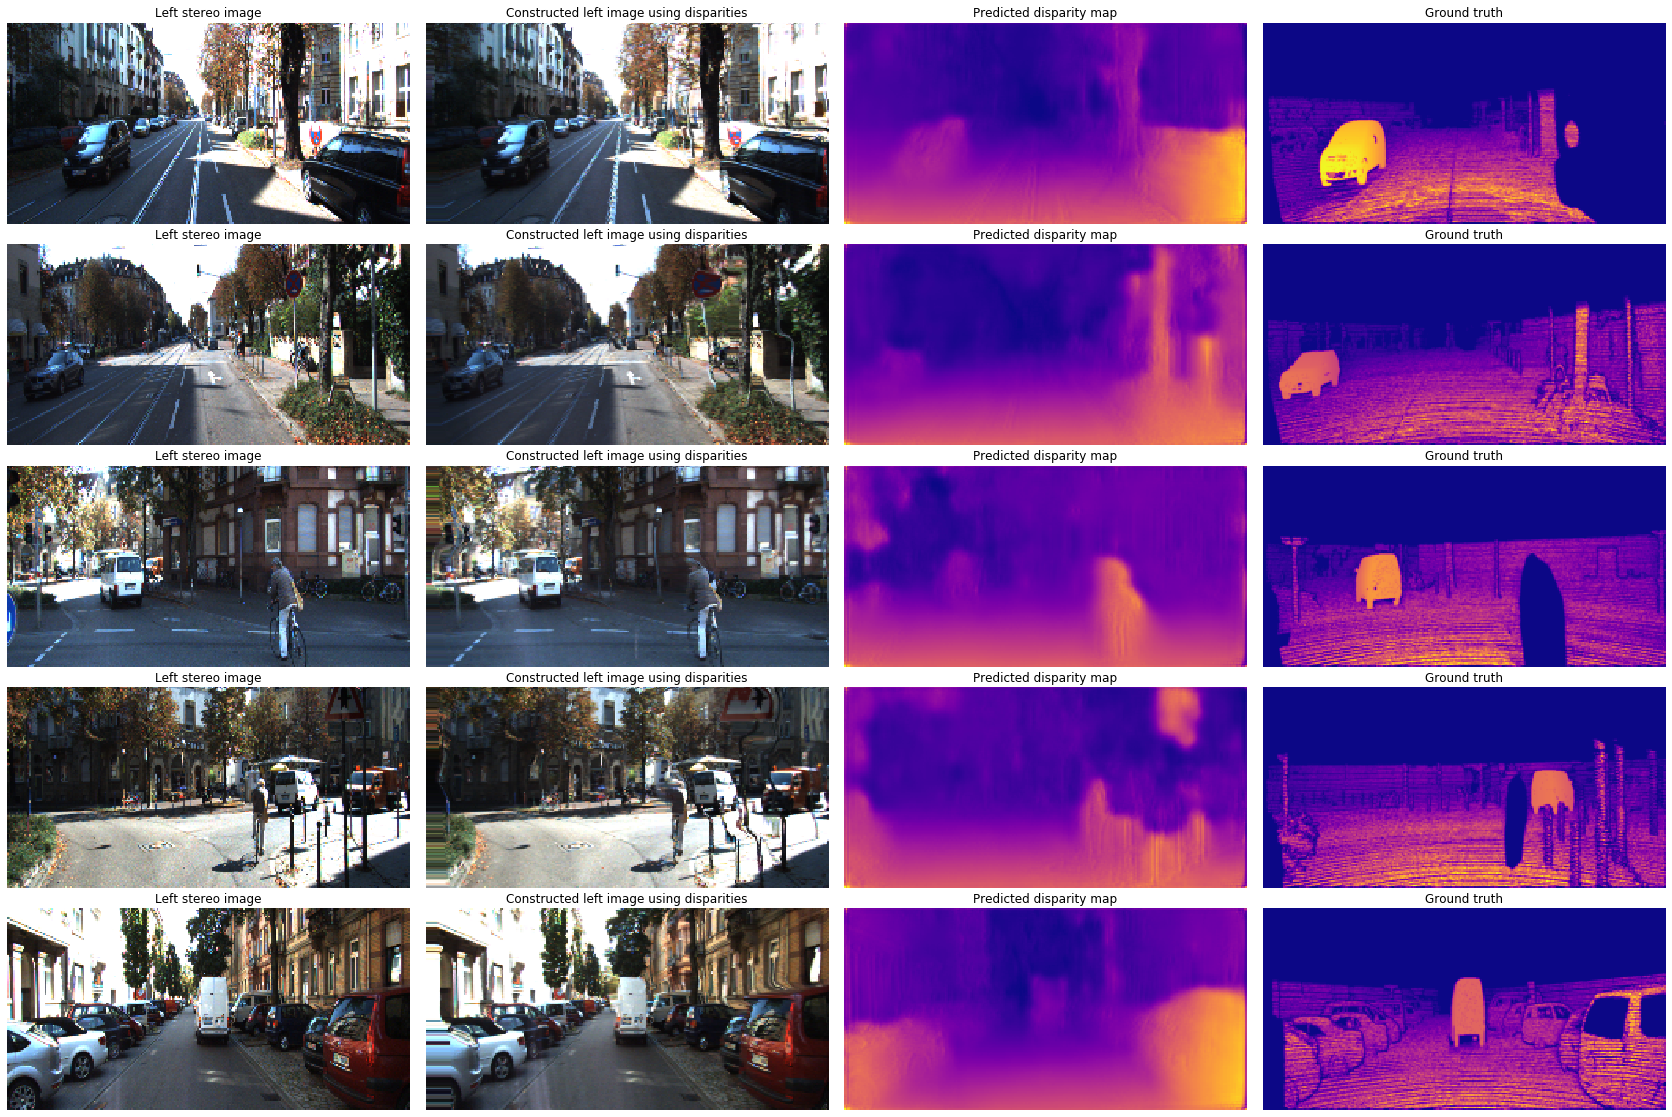

In [0]:
run_on_test(sample_kitti, 0, 5, gt=kitti_gt)

## Conclusions

In the results the model shows that it can reconstruct left images using disparities producing compelling looking shifts. In terms of disparity maps the model is able to identify major objects such as cars and pedestrians. It does struggle near the boundaries of images because of occlusion. A technique that can be done to improve the disparity maps is to run the model again on images reflected left-to-right and combine the 2 disparity maps.

The reproduced model does not produce as impressive results as the model shown in the paper. This is probably due to the fact that we only trained on 10,000 256x128 images rather than 30,000 images 512x256 images. Furthermore the model could probably be trained for longer given more time since the evaluation metrics is still slightly decreasing. 

In conclusion monodepth shows impressive results as an unsupervised approach for depth estimation. The model specified in the paper outperforms all supervised and unsupervised models at the time it was was published. In future work it would be interesting include a reproduction of [Monodepth 2](https://arxiv.org/pdf/1806.01260.pdf) the sucessor to Monodepth.

## References

Godard, C., Aodha, O. M., & Brostow, G. J. (2017). Unsupervised Monocular Depth Estimation with Left-Right Consistency. 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). doi: 10.1109/cvpr.2017.699